# Numerical Verification for Shifted Normals

This notebook verifies the equivalent scale factor methodology for Normal distributions with non-zero means ($\mu \neq 0$). We calculate the analytical weights and then use Monte Carlo simulation to check if the single scale factor produces the matched Expected Positive Value (EPV).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad

## 1. Analytical Weight Calculation

The function below calculates the weights $w_{65}, w_{80}, w_{95}$ by integrating the contributions of each scale factor over the quantile regions defined by the *shifted* distribution $N(\mu, 1)$.

In [2]:
def calculate_analytical_weights(mu=0):
    """
    Calculates weights for N(mu, 1) assuming scale factors are applied 
    based on percentiles of the *underlying distribution* N(mu, 1).
    """
    # Distribution
    dist = norm(loc=mu, scale=1)
    
    # Denominator: Expected Positive Value of X ~ N(mu, 1)
    def integrand_denom(x):
        return x * dist.pdf(x)
    E_total, _ = quad(integrand_denom, 0, np.inf)

    # Helper: Quantile Function based on Percentiles of N(mu, 1)
    q = dist.ppf
    
    u_zero = dist.cdf(0)

    # Helper: Linear Interpolation Integrand
    def integrand(u, u_start, width, weight_type):
        factor = (u - u_start) / width if weight_type == 'rising' else ((u_start + width) - u) / width
        return factor * q(u)
    
    # Omega 65
    o65 = 0
    # Region 1: effectively u_zero -> 0.65 (Extended f65)
    r1_start = u_zero
    r1_end = 0.65
    if r1_end > r1_start:
         val, _ = quad(q, r1_start, r1_end)
         o65 += val
         
    # Region 2 (Falling part of f65): 0.65 -> 0.80
    r2_start = max(u_zero, 0.65)
    r2_end = 0.80
    if r2_end > r2_start:
        val, _ = quad(integrand, r2_start, r2_end, args=(0.65, 0.15, 'falling'))
        o65 += val
    w_65 = o65 / E_total
    
    # Omega 80
    o80 = 0
    # Region 2 (Rising part of f80): 0.65 -> 0.80
    if r2_end > r2_start:
        val, _ = quad(integrand, r2_start, r2_end, args=(0.65, 0.15, 'rising'))
        o80 += val
    # Region 3 (Falling part of f80): 0.80 -> 0.95
    r3_start = max(u_zero, 0.80)
    r3_end = 0.95
    if r3_end > r3_start:
        val, _ = quad(integrand, r3_start, r3_end, args=(0.80, 0.15, 'falling'))
        o80 += val    
    w_80 = o80 / E_total
    
    # Omega 95
    o95 = 0
    # Region 3 (Rising part of f95): 0.80 -> 0.95
    if r3_end > r3_start:
        val, _ = quad(integrand, r3_start, r3_end, args=(0.80, 0.15, 'rising'))
        o95 += val
    # Region 4: 0.95 -> 1.00
    r4_start = max(u_zero, 0.95)
    r4_end = 1.00
    if r4_end > r4_start:
        val, _ = quad(q, r4_start, r4_end)
        o95 += val
    w_95 = o95 / E_total

    return w_65, w_80, w_95

## 2. Verification Function

This function performs the Monte Carlo simulation and compares the result to the analytical prediction. It plots the convergence of the simulated EPV.

In [3]:
def run_verification(mu, n_samples=50_000_000, f65=1.2, f80=1.4, f95=1.3):
    print(f"\n{'='*60}")
    print(f"VERIFICATION FOR MEAN MU = {mu}")
    print(f"{'='*60}")
    
    # 1. Analytical Calculation
    w65, w80, w95 = calculate_analytical_weights(mu)
    f_analytical = w65 * f65 + w80 * f80 + w95 * f95
    
    # Calculate Analytical EPV
    # EPV_base = \int_0^inf x * pdf(x) dx
    dist = norm(loc=mu, scale=1)
    epv_base_analytical, _ = quad(lambda x: x * dist.pdf(x), 0, np.inf)
    epv_total_analytical = f_analytical * epv_base_analytical
    
    print(f"Analytical Weights: w65={w65:.2%}, w80={w80:.2%}, w95={w95:.2%}")
    print(f"Analytical Factor f: {f_analytical:.6f}")
    print(f"Base EPV:            {epv_base_analytical:.6f}")
    print(f"Target Scaled EPV:   {epv_total_analytical:.6f}")

    # 2. Monte Carlo Simulation
    print(f"\nRunning simulation with {n_samples:,} samples...")
    X = np.random.normal(mu, 1, n_samples)
    U = norm.cdf(X, loc=mu, scale=1)
    
    S = np.ones_like(X) * f65 # Default to f65 (covers u <= 0.65)
    
    # Region 2
    mask2 = (U > 0.65) & (U <= 0.80)
    S[mask2] = f65 + (f80 - f65) * (U[mask2] - 0.65) / 0.15
    
    # Region 3
    mask3 = (U > 0.80) & (U <= 0.95)
    S[mask3] = f80 + (f95 - f80) * (U[mask3] - 0.80) / 0.15
    
    # Region 4
    mask4 = (U > 0.95)
    S[mask4] = f95
    
    X_scaled = X * S
    
    # Compute EPV
    # Note: We only average positive values. 
    # Technically E[max(0, Y)] ~ mean(maximum(0, Y))
    epv_simulated = np.mean(np.maximum(0, X_scaled))
    
    print(f"Simulated EPV:       {epv_simulated:.6f}")
    diff = epv_simulated - epv_total_analytical
    print(f"Difference:          {diff:.6f} ({diff/epv_total_analytical:.4%})")
    
    # 3. Convergence Plot
    pos_vals = np.maximum(0, X_scaled)
    # Avoid division by zero warnings for first index
    ns = np.arange(1, n_samples + 1)
    cumulative_means = np.cumsum(pos_vals) / ns
    
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_means, label='Simulated EPV (Cumulative)', color='#1f77b4')
    plt.axhline(y=epv_total_analytical, color='red', linestyle='--', label=f'Analytical Target ({epv_total_analytical:.4f})', linewidth=2)
    
    # Zoom in on last 20%
    plt.xlim(0, n_samples)
    min_y = min(np.min(cumulative_means[int(n_samples*0.1):]), epv_total_analytical)
    max_y = max(np.max(cumulative_means[int(n_samples*0.1):]), epv_total_analytical)
    margin = (max_y - min_y) * 0.1 if max_y != min_y else 0.01
    plt.ylim(min_y - margin, max_y + margin)
    
    plt.title(f'Convergence of Simulated EPV (Mean $\mu={mu}$)')
    plt.xlabel('Number of Samples')
    plt.ylabel('Expected Positive Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

## 3. Run Verification for $\mu=0.5$ and $\mu=-0.5$


VERIFICATION FOR MEAN MU = 0.5
Analytical Weights: w65=32.88%, w80=29.33%, w95=37.79%
Analytical Factor f: 1.296450
Base EPV:            0.697797
Target Scaled EPV:   0.904658

Running simulation with 50,000,000 samples...
Simulated EPV:       0.904671
Difference:          0.000013 (0.0014%)


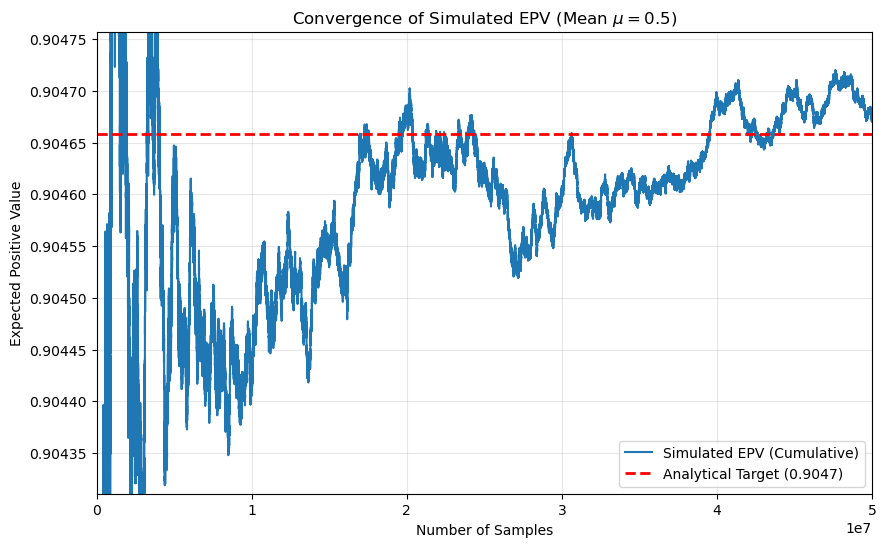


VERIFICATION FOR MEAN MU = -0.5
Analytical Weights: w65=2.14%, w80=27.75%, w95=70.11%
Analytical Factor f: 1.325617
Base EPV:            0.197797
Target Scaled EPV:   0.262203

Running simulation with 50,000,000 samples...
Simulated EPV:       0.262262
Difference:          0.000059 (0.0226%)


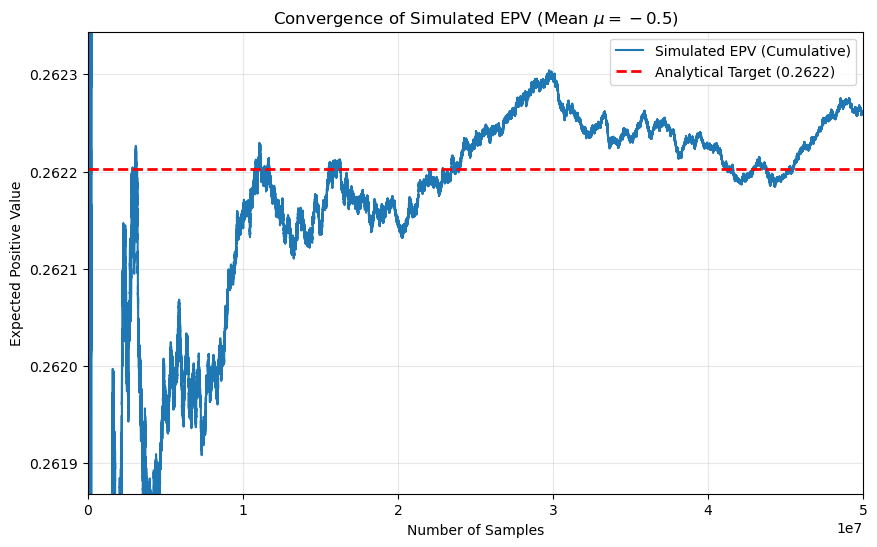

In [4]:
# Test cases
run_verification(mu=0.5)
run_verification(mu=-0.5)